# 3D example
This notebook shows a simple analysis pipeline for running and analyzing a 3D simulation with DISCO-DJ.

I### Imports

In [1]:
# Import modules
import os
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("ticks")
import jax
from jax import config
import numpy as np
from discodj import DiscoDJ
plt.rcParams['image.cmap'] = "rocket"
print(jax.__version__)

0.5.0


In [2]:
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95" # maximize available memory (might need to tune this in case you're running out of memory)

### Simulation settings
DISCO-DJ can be run on a GPU (*much* faster) or on a CPU. The following cell detects if a GPU is available and sets the device accordingly.

In [3]:
# Detect if a GPU is available
devices = jax.devices()
device = "gpu" if np.any([d.platform == "gpu" for d in devices]) else "cpu"
print(device)

gpu


Now, we set the name of the analysis and the spatial dimension. The precision can be set to "single" (float32) or "double" (float64; in that case, the Jax config needs to be updated). DISCO-DJ is written in an class-based (yet functional) way, so you need to define a DiscoDJ object that will be used to perform all computations.

In [4]:
# Set the parameters
name = "3D_analysis"
dim = 3

precision = "single"
if precision == "double":
    config.update("jax_enable_x64", True)

# The cosmology can be provided as a dictionary or a string for a pre-defined cosmology (e.g. "CamelsCV" for the Camels Cosmic Variance suite).
# cosmo = "CamelsCV"
cosmo = dict(Omega_c=0.259605,  # cold dark matter content
             Omega_b=0.0488911,  # baryonic content (note: Disco-DJ so far only performs N-body simulations, no hydro; this is only used for the linear power spectrum!)
             h=0.67742,  # dimensionless Hubble constant
             n_s=0.96822,  # scalar spectral index
             sigma8=0.808992  # amplitude of matter density fluctuations at a scale of 8 Mpc/h
             )


# Define the boxsize and resolution
boxsize = 300.0  # in Mpc/h
res = 128  # the particles live on a Lagrangrian grid of resolution (res)^dim

In [5]:
# Define DISCO-DJ object
dj = DiscoDJ(dim=dim, res=res, name=name, device=device, precision=precision, boxsize=boxsize, cosmo=cosmo)
print(dj)

DiscoDJ
——————————
Name: 3D_analysis
Dimensions: 3D
Resolution: 128³ particles
Boxsize: 300.0 Mpc/h
Precision: single
Device: gpu
Cosmology:
  Omega_c: 0.2596 
  Omega_b: 0.0489 
  Omega_de: 0.6915 
  h: 0.6774 
  n_s: 0.9682 
  sigma8: 0.8090 
  Omega_k: 0.0000 
  w0: -1.0000 
  wa: 0.0000


Next, we compute the timetable for the cosmological growth functions.

In [6]:
# Compute the linear power spectrum
dj = dj.with_timetables()

# If more customization is desired, a dictionary can be passed (see the method "with_timetables()" for more information)
# timetable_settings = {"a_min": 1e-8, "spacing_power": 0.5, "steps": 5000, "a_max": 1.2}
# dj = dj.with_timetables(timetable_settings=timetable_settings)

Now, the linear power spectrum is computed. Options for transfer functions are
* "Eisenstein-Hu": Eisenstein & Hu fitting function from https://arxiv.org/abs/astro-ph/9709112 (default)
* "Disco-EB": Jax-based Einstein-Boltzmann solver, see https://arxiv.org/abs/2311.03291 (accurate, but slower)
* "BBKS": BBKS fitting function from https://articles.adsabs.harvard.edu/pdf/1986ApJ...304...15B
* "GeneticAlgorithm": as determined by a genetic algorithm, see https://arxiv.org/abs/2211.06393
* "from_file": if this option is selected, the function expects a filename of the tabulated power spectrum (NOT a transfer function!). This file should have two columns: $k$ [$h/$Mpc], $P(k)$ [Mpc$^3$/$h^3$], it should be normalized to a = 1 (i.e. z = 0), and should be passed via the `filename=...` argument.
  If you pass `fix_sigma8=True`, the power spectrum normalization will be recomputed to match the value of `dj.cosmo.sigma8`; otherwise, the power spectrum normalization will be assumed to be correct as it is given in the file (no check will be performed).

In [7]:
dj = dj.with_linear_ps(transfer_function="Eisenstein-Hu")
# dj = dj.with_linear_ps(transfer_function="from_file", filename="my_Pk_lin_file.txt", fix_sigma8=True)  # if using a P(k) file

Note that all methods with names `with_...` return new DiscoDJ objects in order to respect Jax's functional programming paradigm and to avoid side effects.

### Initial conditions

In 3D, the NGenic initial conditions generator is also implemented and can be used as follows:

In [8]:
white_noise_field = dj.get_ngenic_noise(seed=24680)  # a white noise field, defined in real space

It is also possible to use the Jax random number generator and to generate a white noise field in Fourier or wavelet space; however, this is not discussed in this notebook.

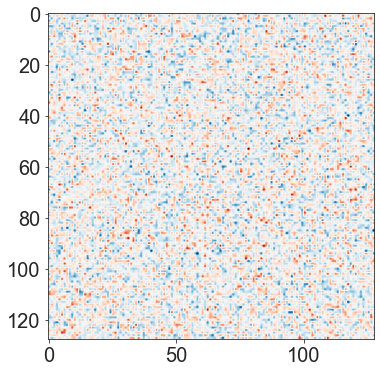

In [9]:
plt.figure(figsize=(6, 6))
plt.imshow(white_noise_field[0, :, :], cmap="RdBu")

Clearly, this is a white noise field, which we can verify by computing its power spectrum (recall that it should be flat):

In [10]:
k_noise, Pk_noise, _ = dj.evaluate_power_spectrum(white_noise_field, compute_std=False, bins=1000)

Text(0, 0.5, '$P(k)$ [$h^{-3}$Mpc$^3$]')

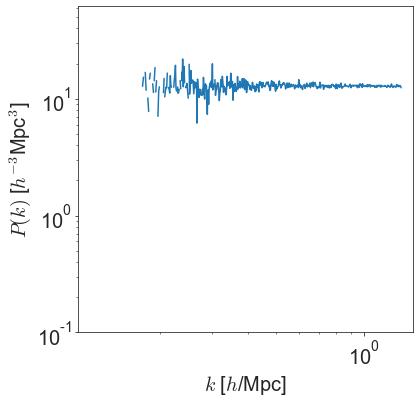

In [11]:
plt.figure(figsize=(6, 6))
plt.loglog(k_noise, Pk_noise)
plt.xlim(5 * np.nanmin(k_noise), 1.1 * dj.k_nyquist)
plt.ylim([1e-1, 2 * np.nanmax(Pk_noise)])
plt.xlabel(r"$k$ [$h$/Mpc]")
plt.ylabel(r"$P(k)$ [$h^{-3}$Mpc$^3$]")

In order to get pre-initial conditions (i.e. "our universe at scale factor $a = 0$") with the correct power spectrum, we need to pass the white noise field to the `with_ics` function.

In [12]:
dj = dj.with_ics(white_noise_space="real", white_noise_field=white_noise_field, convert_to_numpy=True)

In order to save memory on your GPU, you can pass `convert_to_numpy=True` in order to move the generated initial conditions to the CPU. Note, however, that this breaks the differentiability at the Jax - Numpy interface, so don't use this when calling `with_ics()` in case you want to pass gradients through the initial condition generation to the cosmological parameters and/or white noise field.

We can now plot a slice of the initial conditions:

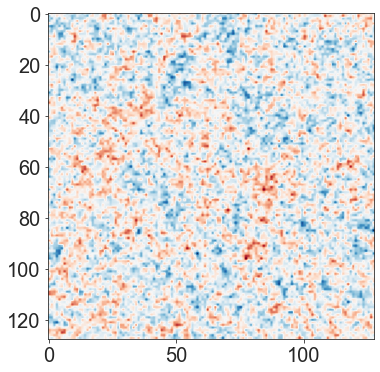

In [13]:
plt.figure(figsize=(6, 6))
plt.imshow(dj.delta_ini[0, :, :], cmap="RdBu")

We can also compute the power spectrum of the pre-initial conditions:

In [14]:
k_pre, Pk_pre, _ = dj.evaluate_power_spectrum(dj.delta_ini, compute_std=False, bins=80)

Text(0, 0.5, '$P(k)$ [$h^{-3}$Mpc$^3$]')

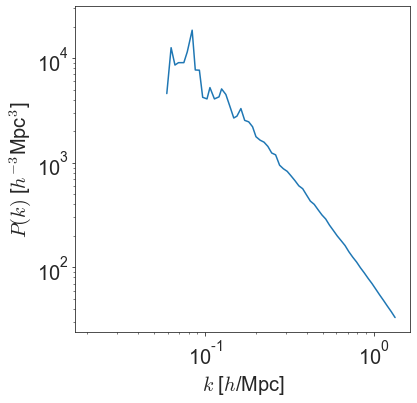

In [15]:
plt.figure(figsize=(6, 6))
plt.loglog(k_pre, Pk_pre)
plt.xlabel(r"$k$ [$h$/Mpc]")
plt.ylabel(r"$P(k)$ [$h^{-3}$Mpc$^3$]")

### Lagrangian perturbation theory (LPT)
Next, we compute the initial conditions with LPT. The order of the LPT computation can be set with the `n_order` parameter. Arbitrary LPT orders are supported, computed
with the recursion relation of Rampf et al., see http://arxiv.org/abs/2010.12584.
Let's use 2LPT ICs here.

In [16]:
n_order = 2
dj = dj.with_lpt(n_order=n_order, convert_to_numpy=True)  # convert_to_numpy as above; note that this breaks differentiability

### Particle-mesh (PM) N-body simulation
Now, we will run a particle-mesh (PM) N-body simulation. The following options need to be set:
- `stepper`: time integrator to use: "bullfrog" (BullFrog, see https://arxiv.org/abs/2301.09655 and https://arxiv.org/abs/2409.19049 for details, default), "fastpm" (FastPM, https://arxiv.org/abs/1603.00476), "symplectic" (standard symplectic integrator)
- `method`: force computation method: choose between "pm" (particle mesh, default) and "nufftpm" (non-uniform FFT-based)
- `res_pm`: resolution of the PM grid per linear dimension, a good choice is often `2 * dj.res`
- `time_var`: time variable w.r.t. which uniform steps are performed (choose between "a", "log_a", "superconft", "D"). For instance, with "log_a" spacing, many steps will be performed at very early times, which is typically unnecessary when using BullFrog, which is "2LPT-informed". For BullFrog, "D" (growth-factor time) is usually a good choice.
- `antialias`: antialiasing factor (0, 1, 2, or 3), an interlaced grid will be used for dealiasing. Defaults to 0.
- `worder`: order of the mass assignment kernel: 2 (cloud-in-cell = CIC, default), 3 (triangular-shaped cloud = TSC), 4 (piecewise cubic spline = PCS)
- `grad_kernel_order`: order of the gradient kernel (0: Fourier kernel $ik$, 2/4/6: 2nd/4th/6th order finite-difference kernel). Defaults to 4 (which acts as a slight low-pass filter). When choosing 0 (exact Fourier kernel), make sure to use sufficient discreteness reduction; otherwise, this will produce inaccurate results.
- `laplace_kernel_order`: order of the Laplacian kernel (0: Fourier kernel $-k^2$, 2/4/6: 2nd/4th/6th order finite-difference kernel). Defaults to 0. The particular choice of the Laplace kernel is usually less important than the gradient kernel.
- `n_resample`: resampling factor (1: no resampling, 2: resample particles 2x per dim., etc.).
      This sheet-based resampling suppresses discreteness effects by artificially increasing the number of gravity-source particles through interpolation. NOTE: this effectively suppresses discreteness at early times, but should not be used in the highly non-linear regime / at late times.
- `deconvolve`: deconvolve the mass assignment kernel (True/False) in the force calculation. Defaults to False.
*Recommendation*: if res_pm = 2 * dj.res, set this to `False` (otherwise small-scale noise is amplified by the deconvolution); if res_pm = dj.res, try setting it to `True`
- `n_steps`: number of time steps to run
- `nlpt_order_ics`: order of the LPT computation for the initial conditions (0: Zel'dovich, 1: 1LPT, 2: 2LPT, etc.), must be less or equal the `n_order` parameter used for `with_lpt()` above.

Note that there are additional options for customizing the NUFFT-based force computation, see the documentation of `run_nbody()`.

In [17]:
# These options should be alright in many scenarios
stepper = "bullfrog"
method = "pm"
res_pm = 2 * dj.res
time_var = "D"
antialias = 0
grad_kernel_order = 4
laplace_kernel_order = 0
worder = 2
n_resample = 1
deconvolve = False
nlpt_order_ics = n_order
chunk_size = None  # if you are running out of GPU memory, doing the mass assignment in smaller chunks might help (e.g. chunk_size = dj.res ** dj.dim // 16)

In [18]:
numsteps = 10  # number of steps to be performed

The method `run_nbody` returns the particle positions, the particle momenta, and the scale factor at the end of the simulation.

In [19]:
a_ini = 0.02  # initial scale factor of the simulation (where it is initialized with LPT)
a_end = 1.0  # final scale factor of the simulation

In [20]:
X_sim, P_sim, a_sim = dj.run_nbody(a_ini=a_ini, a_end=a_end, n_steps=numsteps, res_pm=res_pm,
                                   time_var=time_var, stepper=stepper, method=method, antialias=antialias,
                                   grad_kernel_order=grad_kernel_order, laplace_kernel_order=laplace_kernel_order,
                                   nlpt_order_ics=nlpt_order_ics, n_resample=n_resample,
                                   deconvolve=deconvolve, return_displacement=False, chunk_size=chunk_size,
                                   convert_to_numpy=True)  # convert_to_numpy: same as above for the ICs and LPT

If you need the particle displacement, rather than the final particle positions, set `return_displacement=True`, and the first output will contain $\psi(a, a_{\rm end}) = X(q, a_{\rm end}) - q$ instead of $X(q, a_{\rm end})$.

In [21]:
X_sim.shape

(128, 128, 128, 3)

### Analysis

Let's compute the density field from the particle positions

In [22]:
delta_sim = dj.get_delta_from_pos(X_sim,
                                  res=dj.res,  # number of grid cells
                                  worder=2,  # which mass assignment? 2 = CIC, 3 = TSC, 4 = PCS
                                  deconvolve=False,  # deconvolve the mass assignment kernel?
                                  antialias=False,  # dealias the field with an interlaced grid?
                                  )

Note that we do not deconvolve the mass assignment kernel here; however, this will be done below when computing the power spectrum.

Let's take a look at the density averaged over one dimension and at a density slice:

Text(0.5, 1.0, 'Slice')

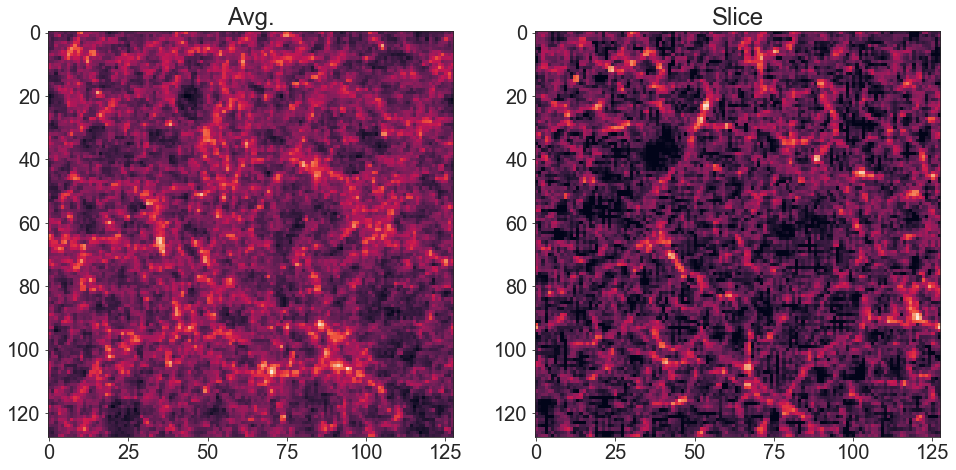

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(np.log10(1.1 + delta_sim.mean(0))); axs[0].set_title("Avg.")
axs[1].imshow(np.log10(1.1 + delta_sim[0, :, :])); axs[1].set_title("Slice")

Let's compute the power spectrum:

In [24]:
k, Pk, _ = dj.evaluate_power_spectrum(delta_sim, bins=dj.res//3, deconvolve=True, worder=2)

We can compare this to the linear expectation of the power spectrum at the final time, as well as the actually realized linear power spectrum for this initial white noise field:

In [25]:
Pk_linear = dj.evaluate_linear_ps(a_end, k)  # linear expectation
_, Pk_linear_realized, _ = dj.evaluate_power_spectrum(dj.delta_ini, bins=dj.res//3)  # linear realization

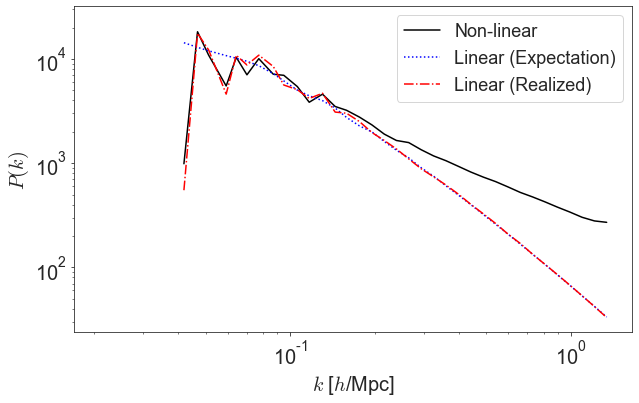

In [26]:
plt.figure(figsize=(10, 6))
plt.loglog(k, Pk, "k-", label="Non-linear")
plt.loglog(k, Pk_linear, "b:", label="Linear (Expectation)")
plt.loglog(k, Pk_linear_realized, "r-.", label="Linear (Realized)")
plt.xlabel(r"$k$ [$h$/Mpc]")
plt.ylabel(r"$P(k)$")
plt.legend(fontsize=18)

# Customizing the density computation

For completeness, let us discuss some additional options for the density computation. For example, a higher resolution can be chosen for the density field with the `res` argument.

In [27]:
delta_sim_2x_res = dj.get_delta_from_pos(X_sim, res=2 * dj.res)

Text(0.5, 1.0, 'Slice')

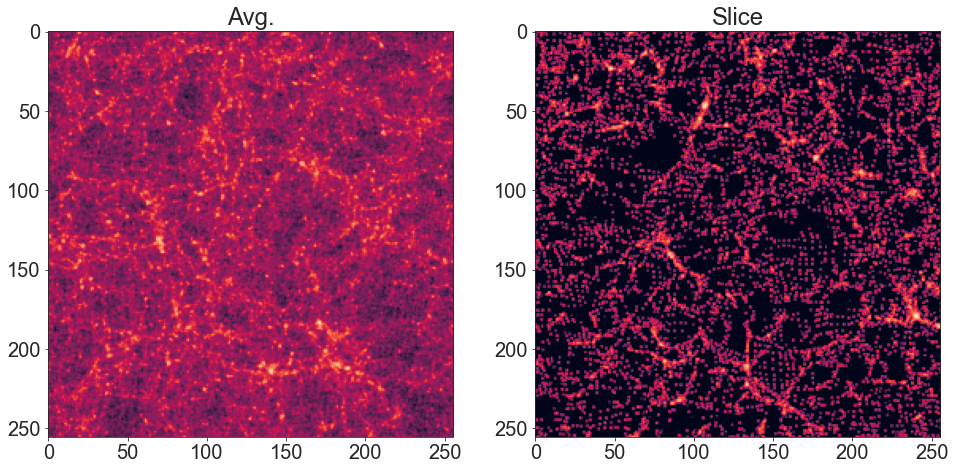

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(np.log10(1.01 + delta_sim_2x_res.mean(0))); axs[0].set_title("Avg.")
axs[1].imshow(np.log10(1.01 + delta_sim_2x_res[0, :, :])); axs[1].set_title("Slice")

The number of particles has not increased, but the density grid has higher resolution, leading to many empty cells (see the black areas in the slice). To fix this, we can artificially increase the number of particles by interpolating on the phase-space sheet (see https://arxiv.org/abs/1501.01959; here, we use Fourier interpolation):

In [29]:
delta_sim_2x_res_resampled = dj.get_delta_from_pos(X_sim, res=2 * dj.res, n_resample=8)

The parameter `n_resample = 8` indicates that each particle shall be copied 8 times per dimension, leading to a total of 8^3 = 512 copies of each particle. The resulting density field looks nicely smooth:

Text(0.5, 1.0, 'Slice')

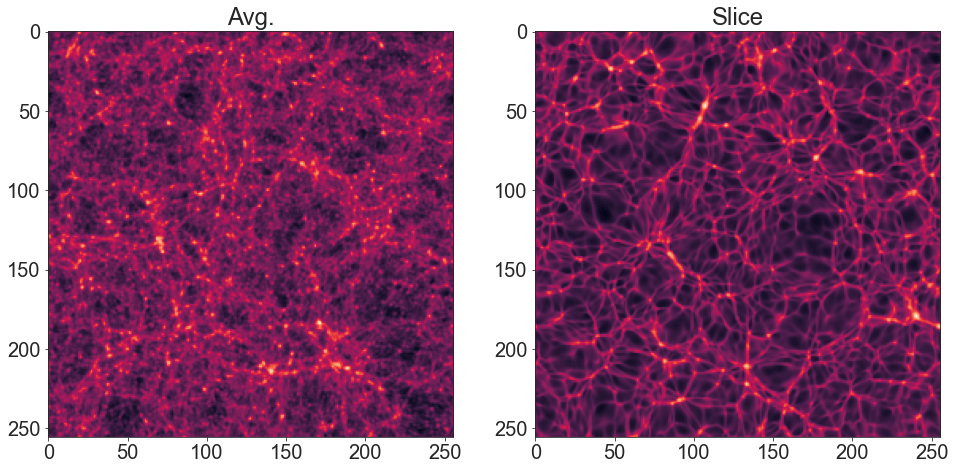

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(np.log10(1.01 + delta_sim_2x_res_resampled.mean(0))); axs[0].set_title("Avg.")
axs[1].imshow(np.log10(1.01 + delta_sim_2x_res_resampled[0, :, :])); axs[1].set_title("Slice")

Apart from the density field, we can also compute other fields of quantities associated with each particle, e.g. the velocity field in z-direction:

In [31]:
vz_field = dj.compute_field_quantity_from_particles(pos=X_sim.reshape(-1, 3), quantity=P_sim.reshape(-1, 3)[:, -1], res=2 * dj.res, n_resample=4, worder=4)

As above, the `worder` parameter specifies the order of the mass assignment (2: CIC, 3: TSC, 4: PCS). The resulting velocity field looks like this:

Text(0.5, 1.0, 'Slice')

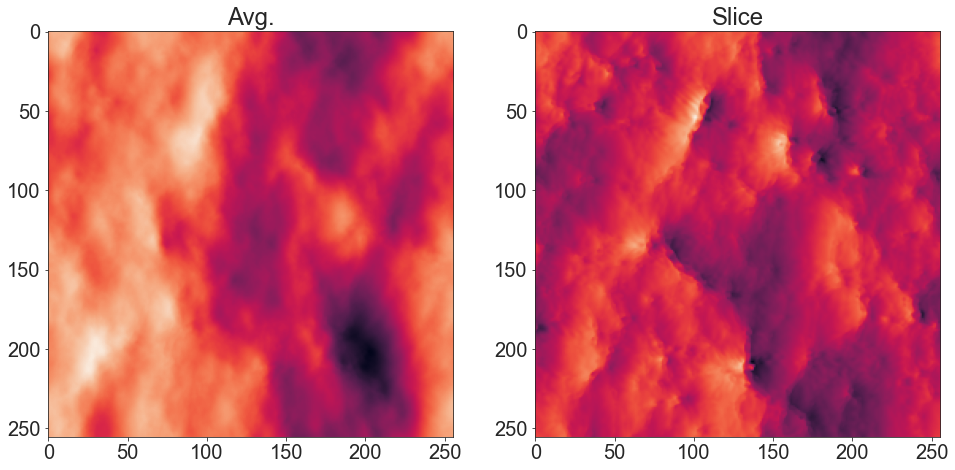

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(vz_field.mean(0)); axs[0].set_title("Avg.")
axs[1].imshow(vz_field[0, :, :]); axs[1].set_title("Slice")

If we are interested in a single slice of a field, we can pass the following parameters:

In [33]:
delta_slice = dj.compute_field_quantity_from_particles(pos=X_sim.reshape(-1, 3), res=8 * dj.res, n_resample=16, worder=4, fixed_inds=[0, None, None])

Here, `fixed_inds` specifies the indices of the dimensions that we are interested in (None stands for "all"). In this case, we are interested in a slice in the x-direction, so we set the y- and z-indices to `None` and the x-index to 0.

Like this, we can compute a slice at a higher resolution much fast than what would be possible for the full box. The resulting slice looks like this:

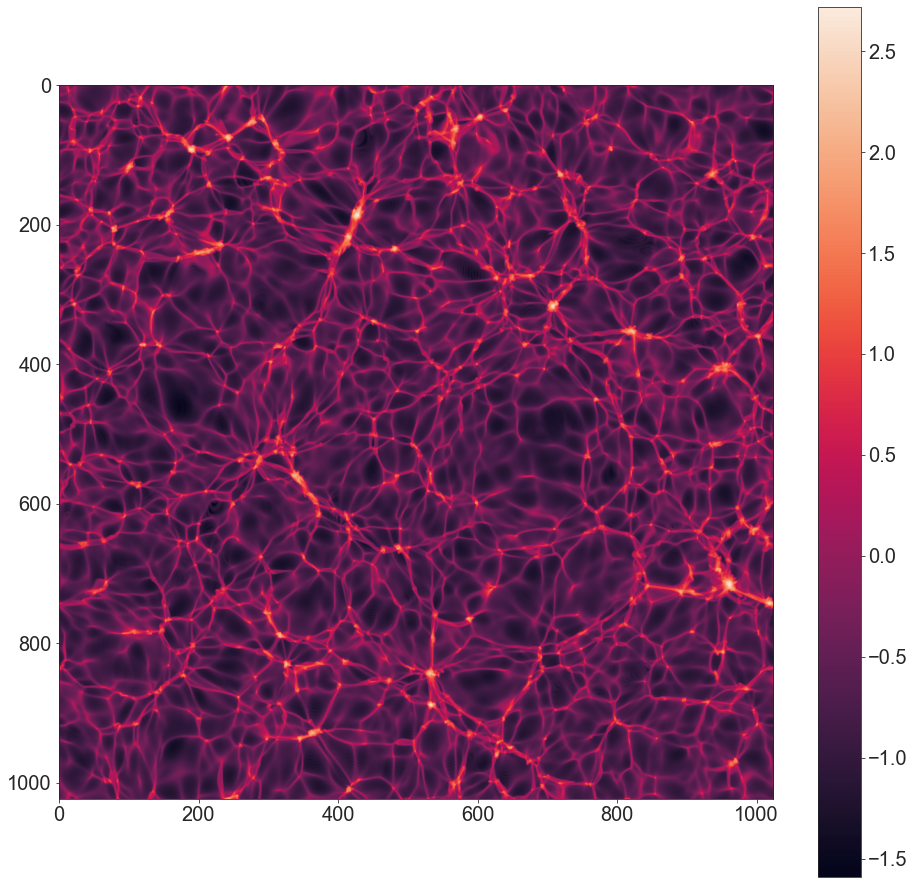

In [34]:
plt.figure(figsize=(16, 16))
plt.imshow(np.log10(1.001 + delta_slice)); plt.colorbar()

Note that when not passing any `quantity` argument to `compute_field_quantity_from_particles` as done here, the density contrast $\delta$ is computed.